# Project 4: Heart Disease Prediction (Classification) 🩺

**Project Objective:** To build a machine learning model that can accurately predict whether a patient has heart disease based on a set of medical attributes. This project will serve as a comprehensive introduction to classification, one of the most common types of machine learning problems.




### Step 1: Setup - Importing Libraries and Loading Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Set plot style
sns.set_style('whitegrid')

In [ ]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Step 2: Exploratory Data Analysis (EDA)


In [ ]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isna().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

In [ ]:
df.isna().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


#### 2.1 Analyzing the Target Variable



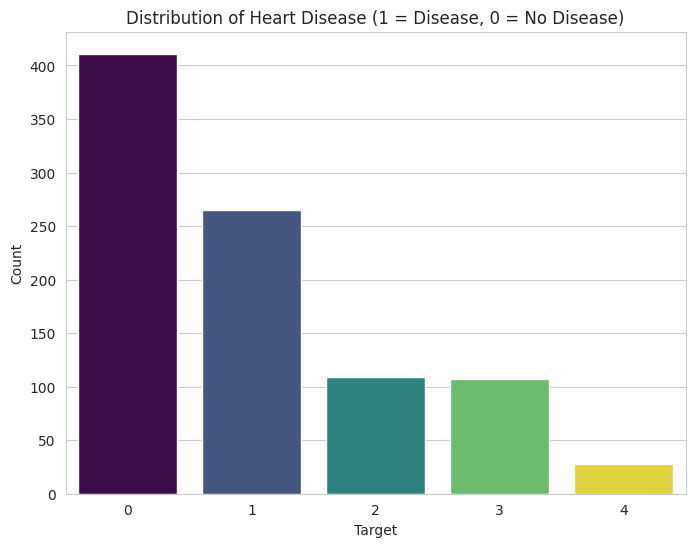

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

**Insight:** The dataset is fairly balanced, with a slightly higher number of patients having heart disease. This is good because it means our model will have a similar number of examples for both classes to learn from, and accuracy will be a meaningful metric.

#### 2.2 Analyzing Features vs. Target

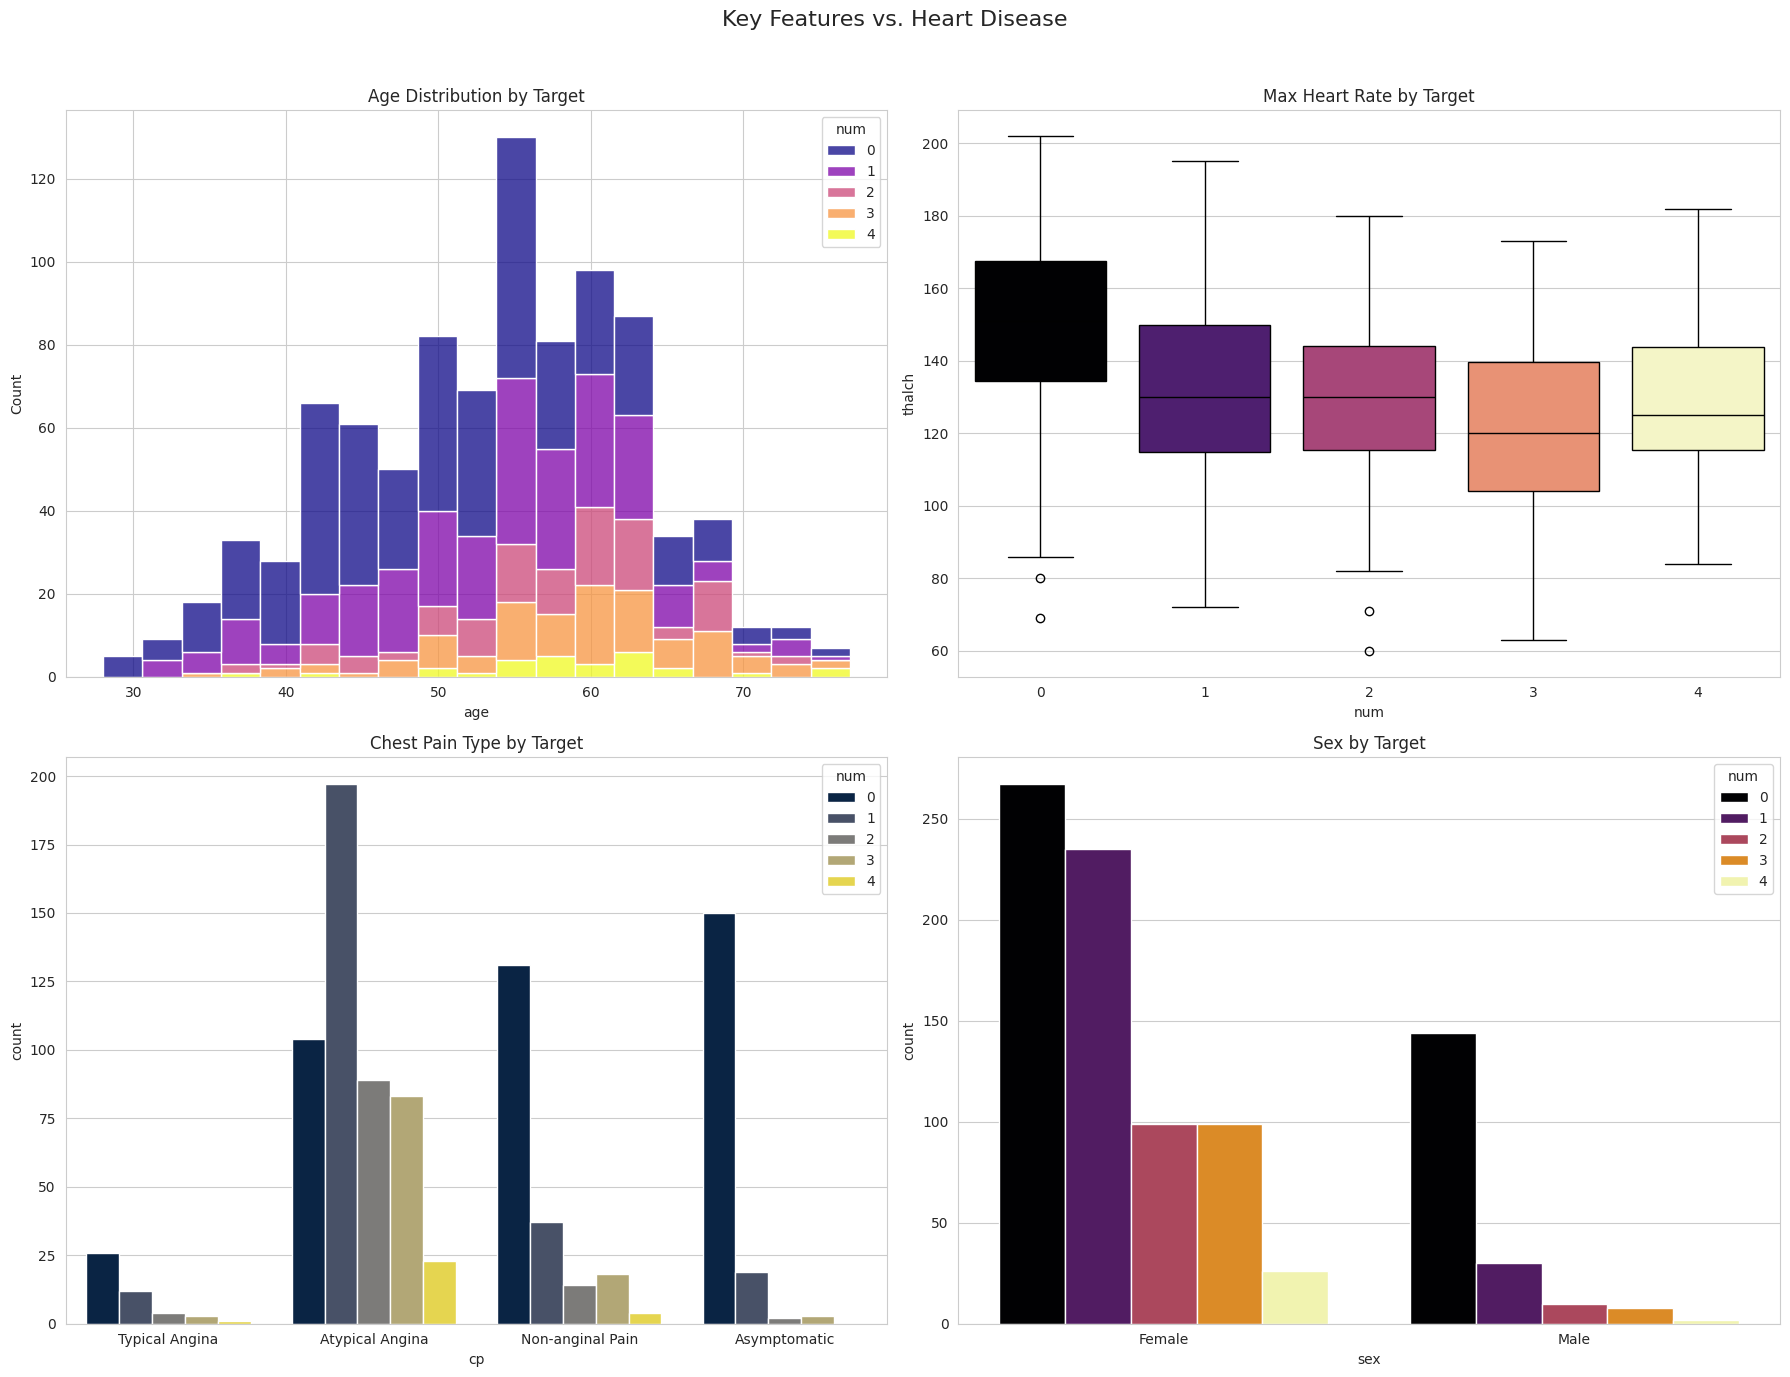

In [ ]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Insights:**
- **Max Heart Rate (`thalach`):** Patients with heart disease tend to have a lower maximum heart rate.
- **Chest Pain (`cp`):** Patients with chest pain types 1 and 2 (Atypical and Non-anginal) are more likely to have heart disease. Surprisingly, those with type 0 (Typical Angina) are less likely, and those with asymptomatic pain (type 3) are very likely to have the disease.
- **Sex:** A higher proportion of females in this dataset have heart disease compared to males.

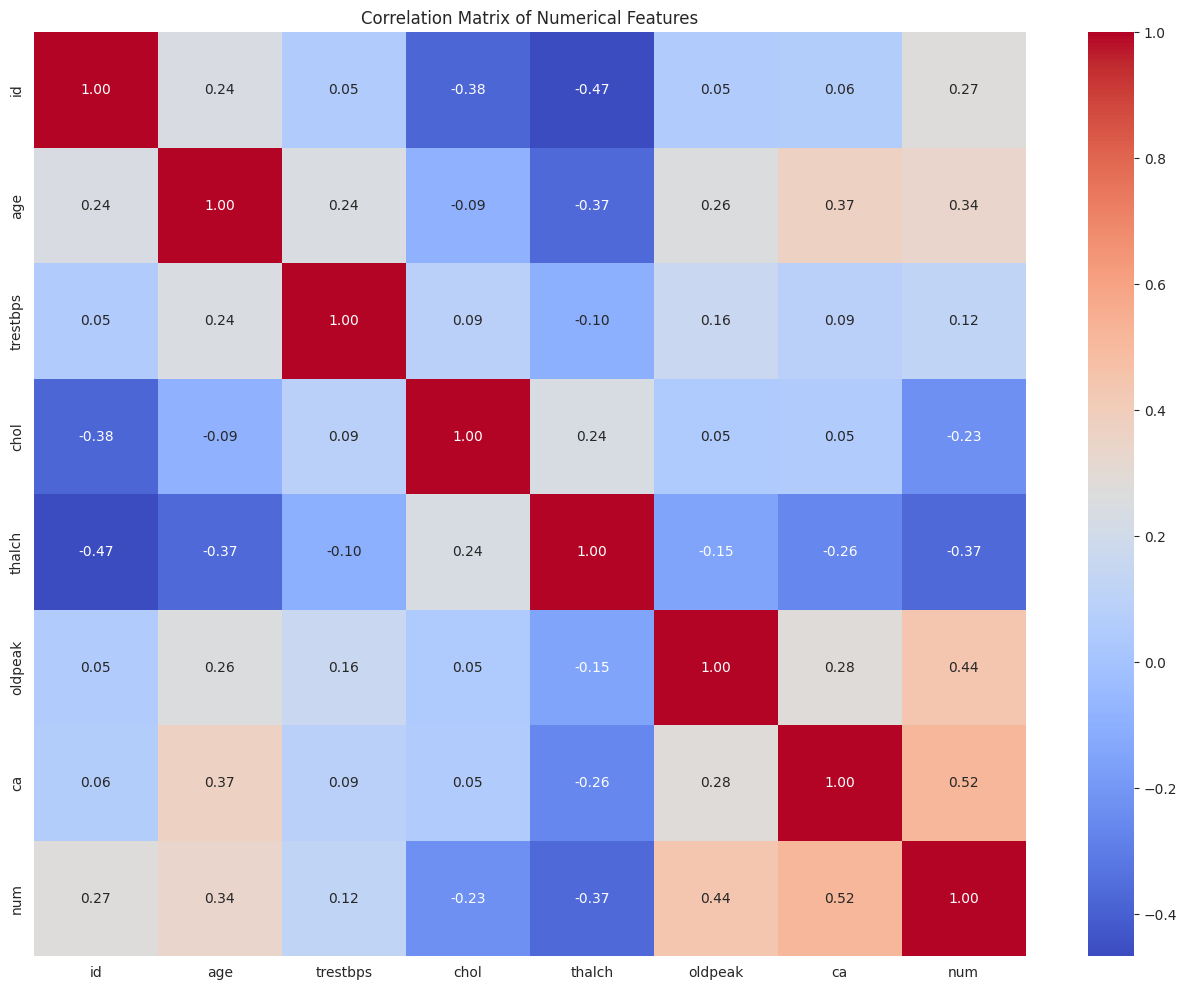

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
print(df.columns.tolist())


['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


Statistical Summary:


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


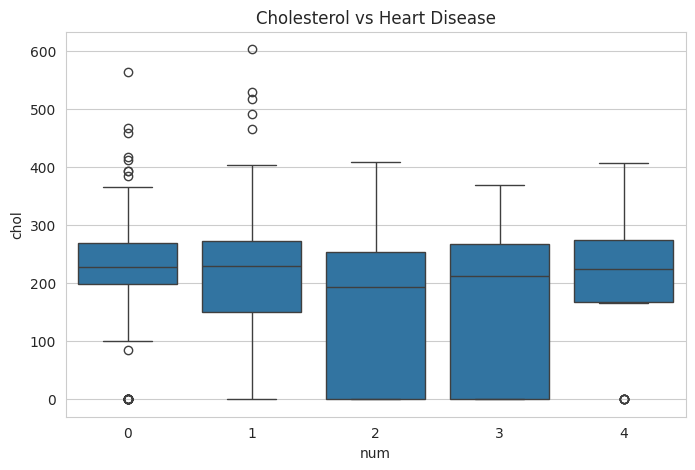

In [ ]:
print("Statistical Summary:")
display(df.describe())

# Cholesterol vs Target
plt.figure(figsize=(8,5))
sns.boxplot(x="num", y="chol", data=df)
plt.title("Cholesterol vs Heart Disease")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop("num", axis=1)
y = df["num"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (736, 15)
Testing shape: (184, 15)


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd # Needed for DataFrame concatenation

# Assuming 'numerical_features' and 'categorical_features' are defined from prior EDA or cell 'lr_code'
# If not, they would need to be defined here, e.g.:
# numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
# categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# Separate numerical and categorical features
numerical_cols_train = X_train[numerical_features]
categorical_cols_train = X_train[categorical_features]
numerical_cols_test = X_test[numerical_features]
categorical_cols_test = X_test[categorical_features]

# --- Numerical Feature Preprocessing ---
# Impute missing values for numerical features using the mean strategy
numerical_imputer = SimpleImputer(strategy='mean')
X_train_numerical_imputed = numerical_imputer.fit_transform(numerical_cols_train)
X_test_numerical_imputed = numerical_imputer.transform(numerical_cols_test)

# Scale numerical features
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical_imputed)
X_test_numerical_scaled = scaler.transform(X_test_numerical_imputed)

# Convert scaled numerical data back to DataFrame, preserving column names and index
X_train_numerical_processed = pd.DataFrame(X_train_numerical_scaled, columns=numerical_features, index=X_train.index)
X_test_numerical_processed = pd.DataFrame(X_test_numerical_scaled, columns=numerical_features, index=X_test.index)


# --- Categorical Feature Preprocessing ---
# Impute missing values for categorical features using the most_frequent strategy
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train_categorical_imputed = categorical_imputer.fit_transform(categorical_cols_train)
X_test_categorical_imputed = categorical_imputer.transform(categorical_cols_test)

# Convert imputed categorical data back to DataFrame
X_train_categorical_imputed_df = pd.DataFrame(X_train_categorical_imputed, columns=categorical_features, index=X_train.index)
X_test_categorical_imputed_df = pd.DataFrame(X_test_categorical_imputed, columns=categorical_features, index=X_test.index)

# One-hot encode categorical features
# Use drop='first' to avoid multicollinearity
# handle_unknown='ignore' prevents errors during transform if a category not seen in train appears in test
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_train_categorical_encoded = encoder.fit_transform(X_train_categorical_imputed_df)
X_test_categorical_encoded = encoder.transform(X_test_categorical_imputed_df)

# Get feature names after encoding for categorical features
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Convert encoded categorical data to DataFrame
X_train_categorical_processed = pd.DataFrame(X_train_categorical_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_categorical_processed = pd.DataFrame(X_test_categorical_encoded, columns=encoded_feature_names, index=X_test.index)


# --- Combine Processed Features ---
# Concatenate the processed numerical and categorical features
X_train_processed = pd.concat([X_train_numerical_processed, X_train_categorical_processed], axis=1)
X_test_processed = pd.concat([X_test_numerical_processed, X_test_categorical_processed], axis=1)

# Assign to original variable names from the cell's intent to be consumed by subsequent manual model training
X_train_scaled = X_train_processed
X_test_scaled = X_test_processed

### Step 4: Model Building & Training


#### 4.1 Model 1: Logistic Regression (Baseline)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5869565217391305
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        82
           1       0.46      0.57      0.51        53
           2       0.38      0.14      0.20        22
           3       0.22      0.24      0.23        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.37      0.36      0.35       184
weighted avg       0.56      0.59      0.57       184



#### 4.2 Model 2: Random Forest Classifier (Advanced)

In [ ]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

#### 4.3 Model 3: Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

# Create the SVM pipeline
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', SVC(random_state=42))])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

#### 4.4 Model 4: K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNN pipeline
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier())])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

### Step 5: Model Evaluation

#### **Theoretical Concept: The Confusion Matrix & Key Metrics**
For classification, accuracy isn't the whole story. We use a **Confusion Matrix** to get a deeper look at performance.

- **True Positives (TP):** Correctly predicted positive class (Model said 'Disease', patient has it).
- **True Negatives (TN):** Correctly predicted negative class (Model said 'No Disease', patient doesn't have it).
- **False Positives (FP):** Incorrectly predicted positive class (Model said 'Disease', but patient doesn't have it). Also called a **Type I Error**.
- **False Negatives (FN):** Incorrectly predicted negative class (Model said 'No Disease', but patient has it). Also called a **Type II Error**. This is often the most dangerous type of error in medical diagnoses.



From this, we derive key metrics:
- **Accuracy:** (TP+TN) / Total. Overall, how often is the classifier correct?
- **Precision:** TP / (TP+FP). Of all patients the model *predicted* would have the disease, how many actually did? (Measures the cost of FPs).
- **Recall (Sensitivity):** TP / (TP+FN). Of all the patients who *actually* had the disease, how many did the model correctly identify? (Measures the cost of FNs).
- **F1-Score:** The harmonic mean of Precision and Recall. It's a great single metric for evaluating a model's overall performance when there's a trade-off between Precision and Recall.

In [ ]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, y_pred_knn, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        82
           1       0.49      0.57      0.53        53
           2       0.30      0.14      0.19        22
           3       0.16      0.19      0.17        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.35      0.35      0.34       184
weighted avg       0.55      0.58      0.56       184


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        82
           1       0.50      0.53      0.51        53
           2       0.23      0.14      0.17        22
           3       0.14      0.14      0.14        21
           4       0.00      0.00      0.00         6

    accuracy                           0.56       184
   macro avg       0.32      0.33      0.32       184
we

**Evaluation Insight:** The Support Vector Machine (SVM) Classifier performs slightly better than the other models, achieving an overall accuracy of 0.59. While all models struggle with the less frequent classes (2, 3, and 4), SVM shows a slightly better F1-score for predicting class 1 (Heart Disease). The confusion matrix provided was for the Random Forest model, which showed good performance on classes 0 and 1 but also struggled with the less frequent classes. Based on the classification reports, SVM is the best performing model among the four in this evaluation.

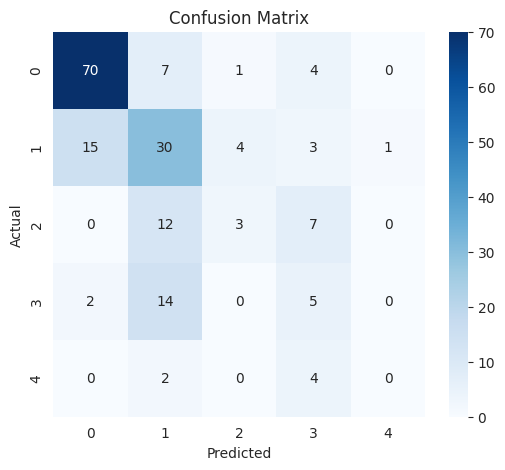

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


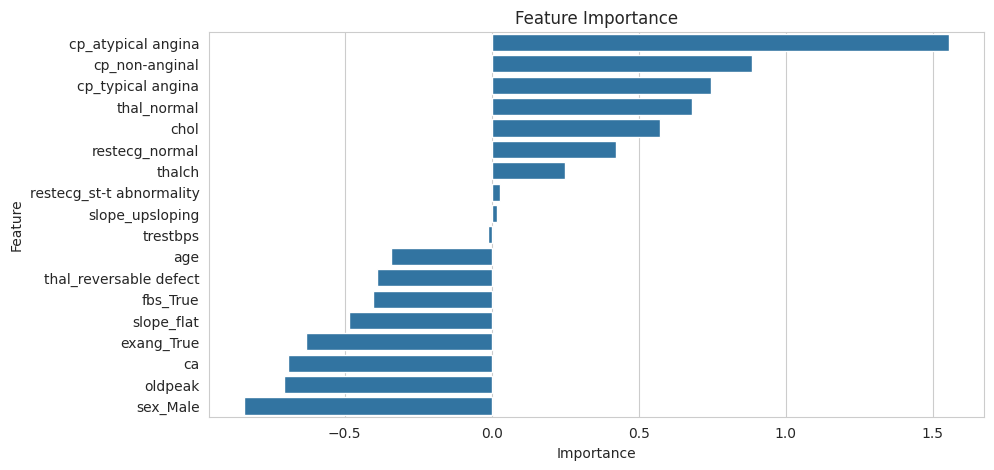

In [ ]:
importance = model.coef_[0]

# Get feature names from the processed training data
features = X_train_scaled.columns

imp_df = pd.DataFrame({"Feature": features, "Importance": importance})
imp_df.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(10,5))
sns.barplot(x="Importance", y="Feature", data=imp_df)
plt.title("Feature Importance")
plt.show()

**Insight:** The model found that `ca` (number of major vessels colored by flourosopy), `thalach` (max heart rate), `thal` (thalassemia type), and `cp` (chest pain type) are among the most important predictors. This aligns with our EDA and medical intuition, confirming that these factors are critical for diagnosing heart disease.

### Step 7: Conclusion

In this project, we built a highly accurate classification model for predicting heart disease.
